In [1]:
import import_ipynb
import numpy as np
import h5py
import torch
from angle_encoding import angle_encoding
from haar_noising import apply_haar_scrambling

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG_train_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)


importing Jupyter notebook from angle_encoding.ipynb
importing Jupyter notebook from haar_noising.ipynb
torch.Size([100, 8, 8, 4])
torch.Size([100, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_14120\1817752611.py:18: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:300.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import matplotlib.pyplot as plt

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers, n_outputs):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self.circuit, self.dev)
        self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits))

    def circuit(self, weights):
        for layer in weights:
            for i in range(self.n_qubits):
                qml.RY(layer[i], wires=i)
                qml.RZ(layer[i], wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[self.n_qubits - 1, 0])  # Connect the last qubit to the first

        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def forward(self, x):
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, self.n_qubits)
        for i in range(batch_size):
            q_out[i] = torch.tensor(self.qnode(self.q_params))
        return q_out
    
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, n_qubits)
        self.dropout2 = nn.Dropout(0.1)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers, n_qubits)
        self.fc3 = nn.Linear(n_qubits, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.quantum_layer(x)
        x = self.fc3(x)
        return x
    
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
n_qubits = 16
n_layers = 1

model = DiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (quantum_layer): QuantumLayer()
  (fc3): Linear(in_features=16, out_features=256, bias=True)
)


Epoch [1/10], Loss: 1.0552
Epoch [2/10], Loss: 1.0077
Epoch [3/10], Loss: 0.9614
Epoch [4/10], Loss: 0.9164
Epoch [5/10], Loss: 0.8725
Epoch [6/10], Loss: 0.8300
Epoch [7/10], Loss: 0.7886
Epoch [8/10], Loss: 0.7486
Epoch [9/10], Loss: 0.7098
Epoch [10/10], Loss: 0.6723


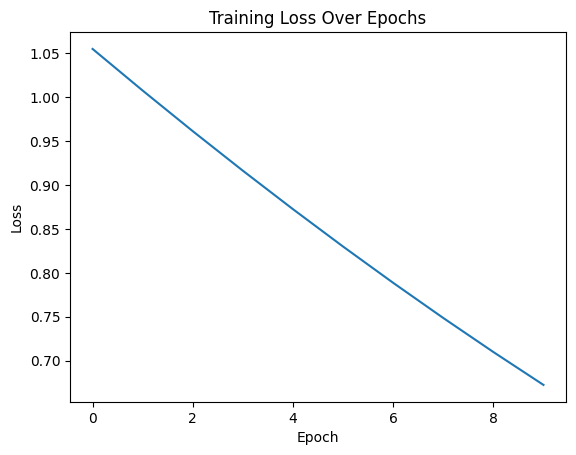

In [3]:
num_epochs = 10
loss_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states.view(num_samples, -1))
    loss = criterion(outputs, encoded_data.view(num_samples, -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

[[[[ 0.12511995  0.12437801  0.08285199  0.01541087]
   [ 0.2402574   0.06584592  0.01047608  0.16217639]
   [ 0.14690402  0.3239623  -0.02291606  0.34869647]
   ...
   [ 0.06323576  0.36933812 -0.01775309  0.21918088]
   [ 0.2922625   0.05446821  0.10221161  0.3047636 ]
   [ 0.23019543  0.1542009  -0.09966486  0.55930394]]

  [[-0.02787398  0.37136063  0.2939437  -0.01478941]
   [ 0.01044521  0.19239539  0.5952363   0.09558712]
   [ 0.4273636   0.14313431  0.14625315  0.3577928 ]
   ...
   [ 0.3048373   0.35549653 -0.02905579  0.14091972]
   [ 0.15087926  0.17745012  0.21854705  0.09529499]
   [ 0.13973966  0.22250369  0.04503289  0.16566288]]

  [[ 0.13505805  0.31684113 -0.03458642  0.09591955]
   [ 0.07565638  0.44689932  0.30981356  0.05673148]
   [ 0.3652338   0.1068951   0.11076501  0.10261975]
   ...
   [ 0.5184933   0.4889299   0.3954773   0.4954091 ]
   [ 0.18158928  0.607445    0.3514858   0.35996932]
   [ 0.13060614  0.35796195  0.2745211   0.51169634]]

  ...

  [[-0.05306

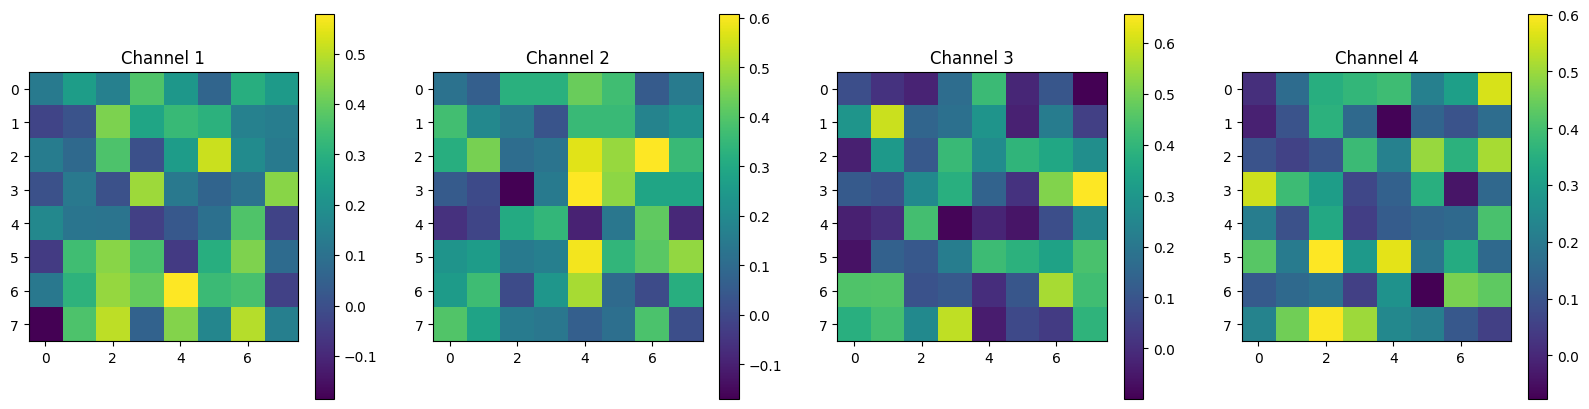

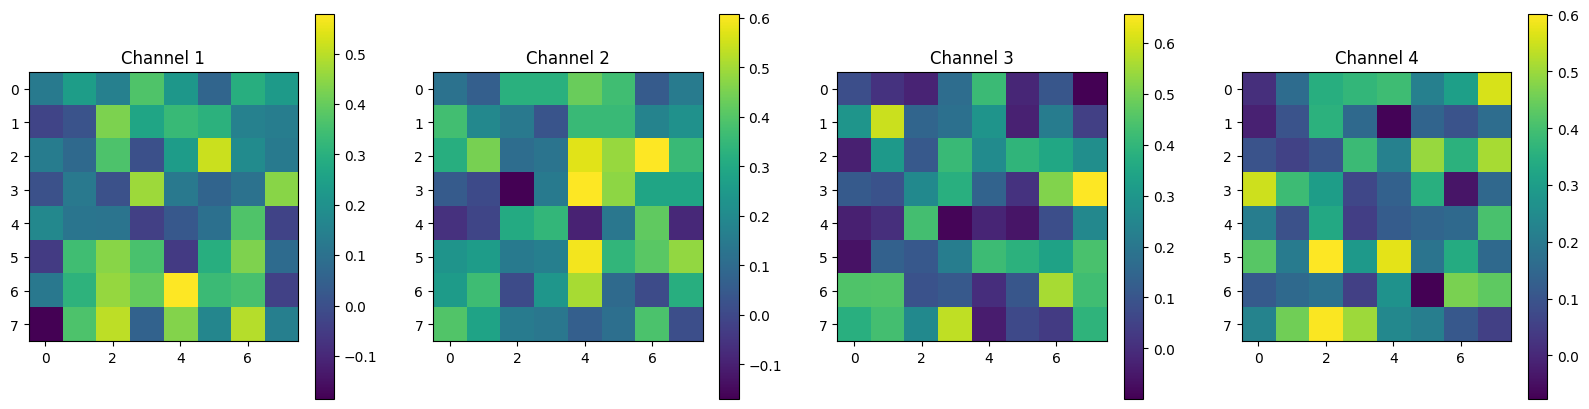

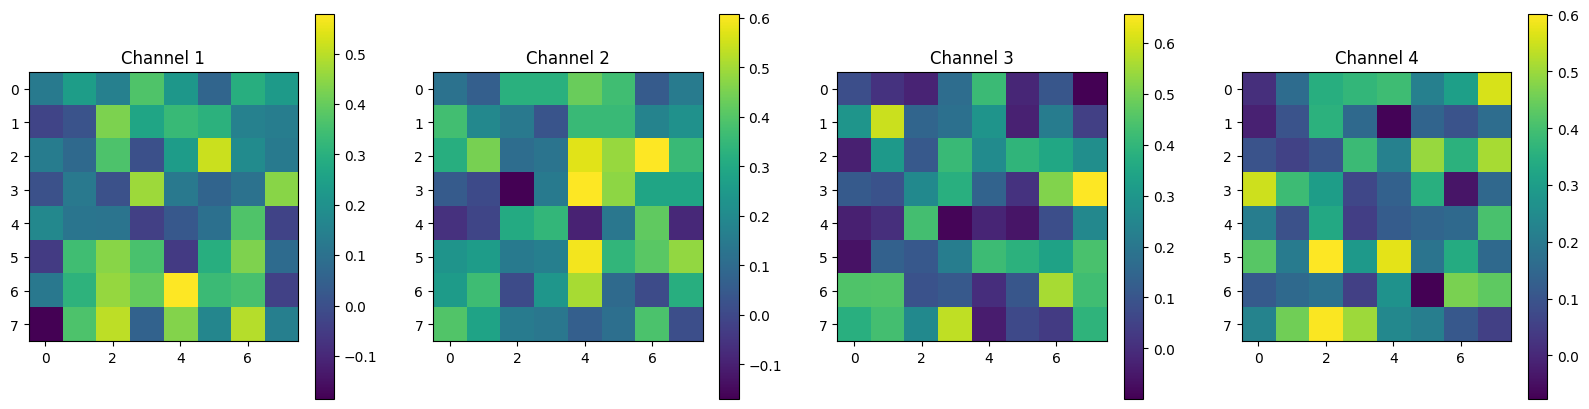

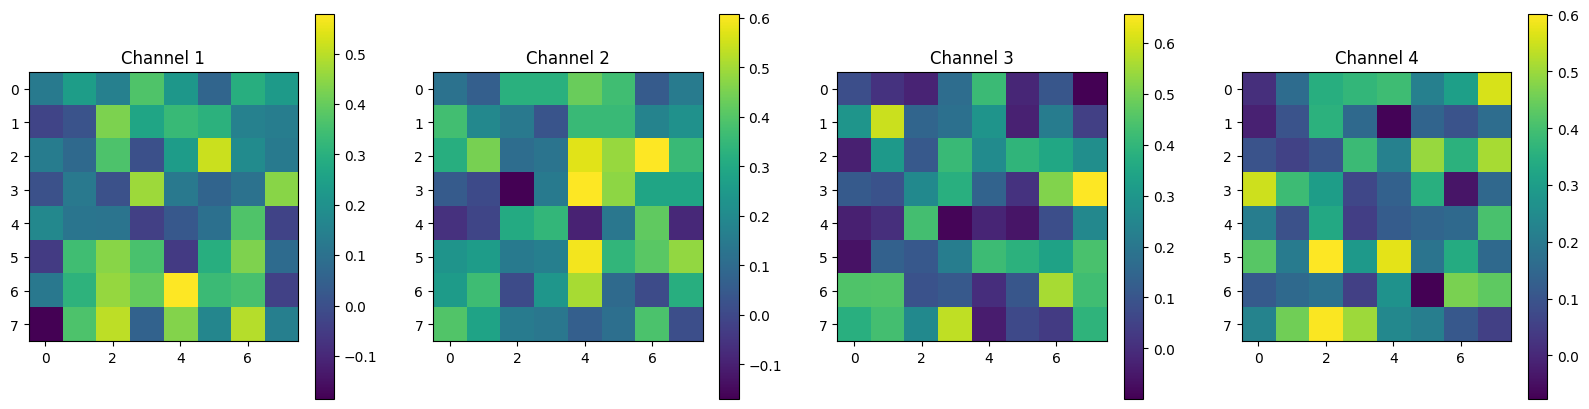

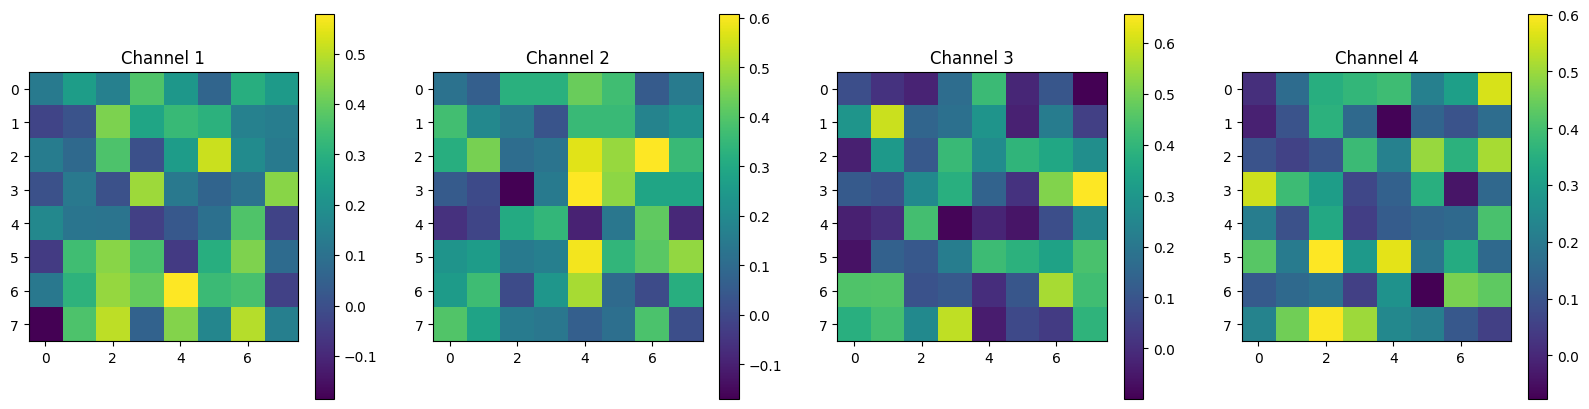

In [4]:
def generate_new_samples(model, num_samples, input_dim):
    random_input = torch.randn(num_samples, input_dim)
    
    model.eval()
    
    with torch.no_grad():
        generated_output = model(random_input)
    
    generated_images = generated_output.view(num_samples, 8, 8, 4).cpu().numpy()
    
    return generated_images

def visualize_generated_images(images):
    for i in range(images.shape[0]):
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Create a figure with 4 subplots side by side
        for channel in range(4):
            ax = axes[channel]
            im = ax.imshow(images[i, :, :, channel], cmap='viridis')
            fig.colorbar(im, ax=ax)
            ax.set_title(f'Channel {channel+1}')
        plt.show()

num_samples_to_generate = 5

generated_images = generate_new_samples(model, num_samples_to_generate, input_dim)
print(generated_images)
visualize_generated_images(generated_images)


(100, 8, 8, 4)
(100000, 16, 16)
(100, 16, 16)


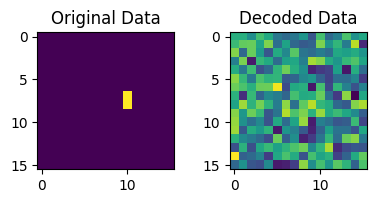

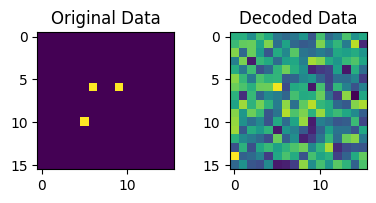

In [6]:
denoised_states = model(scrambled_states.view(num_samples, -1))
denoised_states = denoised_states.view(num_samples, 8, 8, 4).detach().numpy()
print(denoised_states.shape)
print(data_X.shape)

# Decode [num_samples, 8, 8, 4] into 1 channel [num_samples, 16, 16]
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_qubits = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_qubits):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_decoded_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

decoded_data = decode(denoised_states)
decoded_data = flip(decoded_data)
print(decoded_data.shape)

visualize_decoded_data(data_X, decoded_data, sample_index=0)
visualize_decoded_data(data_X, decoded_data, sample_index=1)

In [7]:
import scipy.linalg

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):

    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

mu1, sigma1 = calculate_statistics(data_X)
mu2, sigma2 = calculate_statistics(decoded_data)

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID score: {fid}")

flat_data_X = data_X.reshape(data_X.shape[0], -1)
flat_decoded_data = decoded_data.reshape(decoded_data.shape[0], -1)

FID score: 160.66757546747448


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:209: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


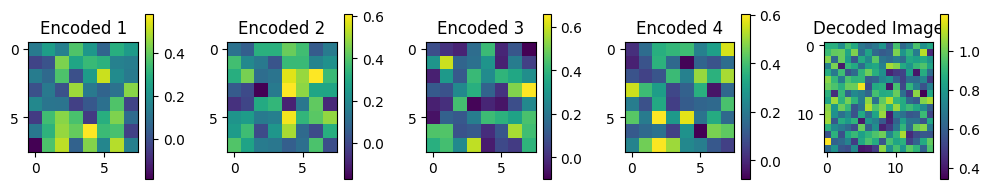

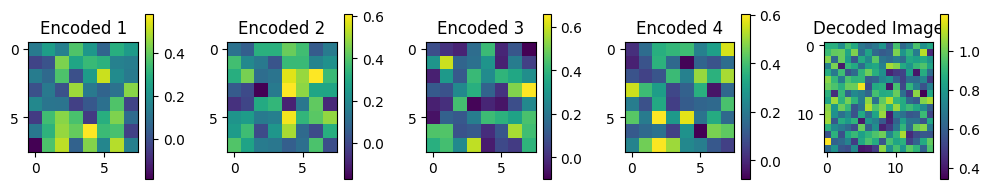

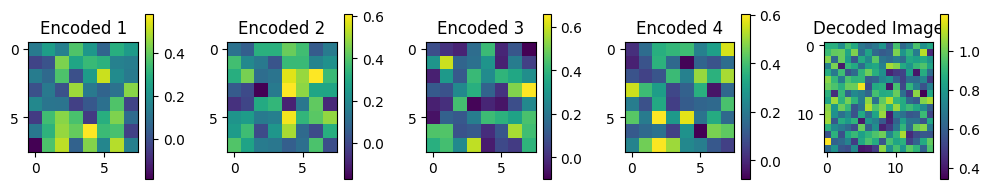

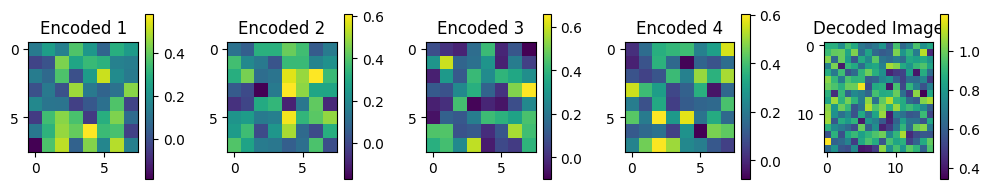

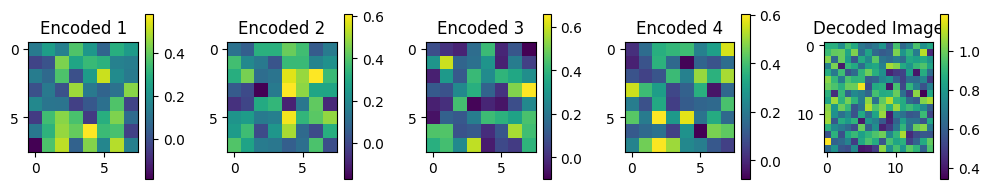

In [10]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded Image")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images


new_images = generate_new_images(model, num_samples_to_generate)